# Migrating to Pyreal

In this tutorial, we'll go through an example of migrating your existing ML pipeline to Pyreal, 
so you can start getting explanations and using your model more effectively.

## Tutorial goals
1. Learn how to migrate your existing data transformers to the Pyreal framework
2. Learn how to create a `RealApp` from an existing model
3. Learn how to use your new `RealApp` to interact with and understand your ML model

In this tutorial, we will use the [Titanic dataset](https://www.kaggle.com/c/titanic/data)

## Problem setup

In this tutorial, we will assume you have the following inputs:
1. A pretrained ML model (an object with a `.predict()` method, that takes in input data and outputs a prediction)
2. A dataset (a pandas DataFrame) used that train explanation methods
3. Input data that you'd like to get predictions and explanations for
4. Optionally, data transformers used to transform the dataset and input data into the feature space expected by the ML model.

We will go through two examples of migrating to Pyreal: first, using the `from_sklearn` function, useful 
when your original inputs use an sklearn pipeline, and second using the Pyreal transformer module to manually 
wrap your transformers.

## Migrating from Sklearn Pipelines

In this example, we will demonstrate migrating to Pyreal from an sklearn pipeline using the `from_sklearn` function.
In the code cell below, we set up a basic sklearn pipeline that uses the Titanic dataset to predict survival.


In [1]:
from pyreal.sample_applications import titanic

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Define the column transformer
categorical_transforms = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                         ('onehot', OneHotEncoder(sparse_output=False))])
preprocessor = ColumnTransformer(
    transformers=[
        ('column_dropper', 'drop', ["PassengerId", "Name", "Ticket", "Cabin"]),  # Drop columns
        ('mean_imputer', SimpleImputer(strategy='mean'), ["Pclass", "Age", "SibSp", "Parch", "Fare"]),  # Impute with mean
        ('categorical_transformer', categorical_transforms, ["Sex", "Embarked"])
    ]
)

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingClassifier())  # Step 5: Logistic Regression
])

X_train, y_train = titanic.load_data(include_targets=True)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('column_dropper', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Ticket', 'Cabin']),
                                                 ('mean_imputer',
                                                  SimpleImputer(),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['Sex', 'Embarked'])])),
                ('model', GradientBoostingClassifier())])

For simple sklearn pipelines like this one, you can quickly migrate the pipeline to Pyreal using the `from_sklearn` function, as shown below.
We set the verbosity to 1, so we can review the transformers created and ensure they make sense.

See the final section of this tutorial for examples of using the resulting RealApp object.

In [2]:
from pyreal import RealApp

real_app = RealApp.from_sklearn(pipeline, X_train=X_train, y_train=y_train, verbose=1)

Adding ColumnDropTransformer for columns ['PassengerId', 'Name', 'Ticket', 'Cabin']
Adding SimpleImputer() for columns ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Adding SimpleImputer(strategy='most_frequent') for columns ['Sex', 'Embarked']
Adding OneHotEncoder for columns ['Sex', 'Embarked']
Skipping step GradientBoostingClassifier() as it does not appear to be a transformer


## Manually setting up Pyreal transformers

In some cases, the `from_sklearn` function may not be able to infer the correct transformers from your sklearn pipeline.
In particular, this will happen if your code uses custom transformers that add, remove, or aggregate features and are not currently supported by Pyreal by default.

Additionally, you may have your transformers in a different format than an sklearn pipeline. In these cases, you can set up your app by manually creating Pyreal transformers.
For each data transformer, there are three possibilities:

1. If an equivalent transformer exists in Pyreal, you can use the Pyreal transformer directly. This is recommended when possible as using Pyreal transformers will result in more interpretable explanations. See the [Pyreal transformer documentation](https://sibyl-ml.dev/pyreal/api_reference/transformer.html) for the full list of supported transformers.


In [3]:
from pyreal.transformers import OneHotEncoder, ColumnDropTransformer

column_dropper = ColumnDropTransformer(columns=["PassengerId", "Name", "Ticket", "Cabin"])
one_hot_encoder = OneHotEncoder(columns=["Sex", "Embarked"])

2. For simple transformations that operate on a single feature, you can use the [`pyreal.Transformer`](https://sibyl-ml.dev/pyreal/api_reference/api/pyreal.transformers.Transformer.html#pyreal.transformers.Transformer) class to wrap your transformer. 

In [4]:
from pyreal.transformers import Transformer

# Assuming your transformer is an object with a .transform() method, you can use:
#      pyreal.Transformer(transformer, columns=COLUMNS_TO_OPERATE_ON)
categorical_imputer = Transformer(categorical_transforms['imputer'], columns=["Sex", "Embarked"])

# If instead your transformer is a function that takes in data and returns the transformed data, you can instead use:
#      pyreal.Transformer.from_transform_function(transform_function)
def numeric_impute(x):
    x_trans = x.copy()
    x_trans[["Pclass", "Age", "SibSp", "Parch", "Fare"]].fillna(x[["Pclass", "Age", "SibSp", "Parch", "Fare"]].mean())
    return x_trans

numeric_imputer = Transformer.from_transform_function(numeric_impute)

3. For more complex data transformations that add, remove, or aggregrate features, you can still use the options in step 2 but will need to make sure your original transform() function takes in and returns data as a pandas dataframe. Alternatively, you can extend the `TransformerBase` class to create your own custom Pyreal transformer. See the [custom transformer tutorial](https://github.com/sibyl-dev/pyreal/blob/dev/tutorials/custom_transformers.ipynb) for more details on this process.

Once you have your pyreal transformers set up, you can initialize your RealApp object:

In [8]:
from pyreal.transformers import fit_transformers

transformers = [column_dropper, categorical_imputer, numeric_imputer, one_hot_encoder]
fit_transformers(transformers, X_train)

# We define a functions to present the predictions in a more readable format
pred_format_func=lambda x: "Survived" if x else "Died"
real_app = RealApp(pipeline['model'], transformers=transformers, X_train_orig=X_train, y_train=y_train, pred_format_func=pred_format_func)

## Using the RealApp object
Now that your RealApp is set up, you can get model predictions and generate explanations.

Predictions: {0: 'Died', 1: 'Survived', 2: 'Died'}


X has feature names, but GradientBoostingClassifier was fitted without feature names


,Feature Name,Importance
PassengerId,PassengerId,0.000000
Pclass,Pclass,0.561018
Name,Name,0.000000
Sex,Sex,0.906257
Age,Age,1.234344


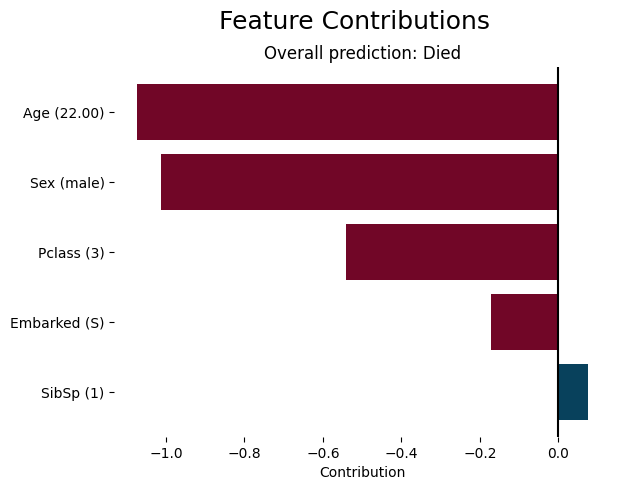

In [14]:
from pyreal.visualize import feature_bar_plot

passengers_of_interest = X_train.iloc[0:3]

# Get model predictions
predictions = real_app.predict(passengers_of_interest)
print("Predictions:", predictions)

# Get global importance
importance = real_app.produce_feature_importance()
display(importance.head())

# Get local contributions
contributions = real_app.produce_feature_contributions(passengers_of_interest)
feature_bar_plot(contributions[0], prediction=predictions[0])